Sound length 80000
Sampling Rate: 16000
Window length 320
Shift length: 160
Num window:  499


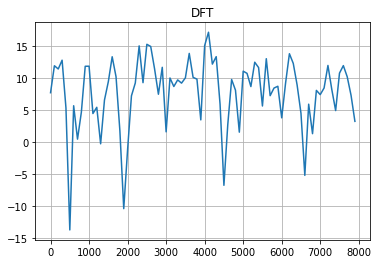

In [64]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal
from playsound import playsound
import wavio

class SpeechProcessing(object):
    
    def __init__(self):   
        import numpy as np
    
    def window(self, x, fs, window_dur_in_second, frame_shift):
        import numpy as np
        sound_length = len(x)
        window_length = int(fs*window_dur_in_second)
        shift_length = int(fs*frame_shift)
        num_window = int((sound_length-window_length)/shift_length + 1)

        print("Sound length", sound_length)
        print("Sampling Rate:", fs)
        print("Window length", window_length)
        print("Shift length:",shift_length)
        print("Num window: ",num_window)

        windowed_data = []

        for i in range(int(num_window)):
            window = [0.54-0.46*np.cos((2*3.14*i)/(window_length-1)) for i in range(window_length)]
            frame = x[(i*shift_length):(i*shift_length)+window_length]*window
            windowed_data.append(frame)

        return windowed_data
    
    
    def shortTimeZeroCrossing(self, windowed_data, frame_shift, fs):
        
        shift_length = int(fs*frame_shift)
        
        import numpy as np
        zc_vector = []
        
        for frame in (windowed_data):
            sum = 0
            for i in range(len(frame)-1):
                first_element = frame[i]
                second_element = frame[i+1]
                element = np.abs(np.sign(first_element)-np.sign(second_element))
                sum = sum + element
            zc = (shift_length*sum)/(len(frame)*2)
            zc_vector.append(zc)#her window için tek bir zc değeri
    
        zc_vector = np.array(zc_vector).reshape((len(windowed_data),1))
        #zc_vector = zc_vector/max(zc_vector)
        #zc_vector = 10*np.log10(zc_vector)
        
        return zc_vector
    
    
    def shortTimeEnergy(self, windowed_data):
        import numpy as np
        energy_Vector = []
        sum = 0
        for frame in (windowed_data):
            sum = 0
            for i in range(len(frame)):
                sum = sum + frame[i]*frame[i]
            energy_Vector.append(sum)
        
        energy_Vector = np.array(energy_Vector).reshape((len(windowed_data),1))
        energy_Vector = energy_Vector/max(energy_Vector)
        energy_Vector = 10*np.log10(energy_Vector)
        
        return energy_Vector
    
    
    def endPointDetector(self, shortTimeEnergy, shortTimeZeroCrossing, window_dur_in_second, frame_shift, fs):
        import numpy as np
        #100ms to frame count:
        frame_count = int(0.1/window_dur_in_second)
        energy = shortTimeEnergy[:frame_count]
        zc = shortTimeZeroCrossing[:frame_count]
        
        av_energy = np.mean(energy)
        av_zc = np.mean(zc)
        std_energy = np.std(energy)
        std_zc = np.std(zc)
        
        IF = 35
        IZCT = max(IF, av_zc + 3*std_zc)
        ITU = -15 #constant in range of -10 to -20dB
        ITR = max(ITU-10, av_energy + 3*std_zc)
        
         #Find B1**********************************
        B1 = 0
        for i in range(len(shortTimeEnergy)-15):
            amplitude = shortTimeEnergy[i]
            frame = shortTimeEnergy[i:i+15]
            
            if amplitude >= ITR:
                if np.mean(frame)>ITU:
                    B1 = i
                    break    
        #****************************************** 
        #Find E1**********************************
        E1 = 0
        for i in range(len(shortTimeEnergy)-1,15,-1):
            amplitude = shortTimeEnergy[i]
            frame = shortTimeEnergy[i-15:i]
            
            if amplitude >= ITR:
                if np.mean(frame)>ITU:
                    E1 = i
                    break 
         #******************************************   
        #Find B2**********************************
        B2 = B1
        counter = 0
        for i in range(B1,B1-25,-1):
            amplitude = shortTimeZeroCrossing[i]
            if amplitude > IZCT:
                counter += 1
         
        if counter>4:
            for i in range(len(shortTimeZeroCrossing)):
                amplitude = shortTimeZeroCrossing[i]
                if amplitude > IZCT:
                    B2 = i
                    break
        #******************************************   
        #Find E2**********************************
        E2 = E1
        counter = 0
        for i in range(E1,E1+25,1):
            amplitude = shortTimeZeroCrossing[i]
            if amplitude > IZCT:
                counter += 1
        
        if counter>4:
            for i in range(len(shortTimeZeroCrossing)-1,E1,-1):
                amplitude = shortTimeZeroCrossing[i]
                if amplitude > IZCT:
                    E2 = i
                    break
        #******************************************
        
        time_id_B1 = (frame_shift)*B1
        sample_id_B1 = int(time_id_B1*fs)
        time_id_E1 = (frame_shift)*E1
        sample_id_E1 = time_id_E1*fs
        time_id_B2 = (frame_shift)*B2
        sample_id_B2 = int(time_id_B2*fs)
        time_id_E2 = (frame_shift)*E2
        sample_id_E2 = int(time_id_E2*fs)
        
        print("ITR: ",ITR,"|ITU: ",ITU,"|IZCT: ",IZCT)
        print("Frame ID B1:",B1, "|Frame ID E1:", E1, "|Frame ID B2:",B2,"|Frame ID E2:",E2)
        print("Start id: ",sample_id_B2," End id:", sample_id_E2)
        
        return sample_id_B2, sample_id_E2
    
    
    
    def STFT(self, windowed_data, N, fs):
        
        STFT = []
        dft_frame = []
        
        for frame in windowed_data:            
            
            dft_frame = np.fft.fft(frame,N)
            STFT.append(dft_frame)
            
            t = np.arange(0, N, 1)
            f = np.arange(0,fs/2,fs/N)
            plt.plot(f,20*np.log10(np.abs(dft_frame[:int(len(dft_frame)/2)])))
            plt.grid(True)
            plt.title("DFT")
            break

        return STFT

#MAIN******************************************************



#Read Sound
fs, data = wavfile.read('3.wav')
  
#Highpass Filtering - 101 Point FIR Filter
b = signal.firwin(101, cutoff=100, fs=fs, pass_zero=False)
data = signal.lfilter(b, [1.0], data)

#Short Time Speech Processing
speech = SpeechProcessing()
windowed_sound = speech.window(data,fs, window_dur_in_second = 0.02, frame_shift = 0.01)
#shortTimeZeroCrossing = speech.shortTimeZeroCrossing(windowed_sound, frame_shift = 0.01, fs = fs)
#shortTimeEnergy = speech.shortTimeEnergy(windowed_sound)
#start_id, end_id = speech.endPointDetector(shortTimeEnergy,shortTimeZeroCrossing,window_dur_in_second=0.02, frame_shift = 0.01,fs=fs)
STFT = speech.STFT(windowed_sound, 160, fs)



### Short Time Analysis

Text(0.5, 0, 'frames')

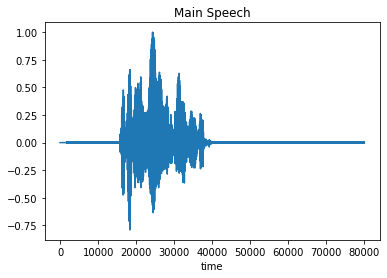

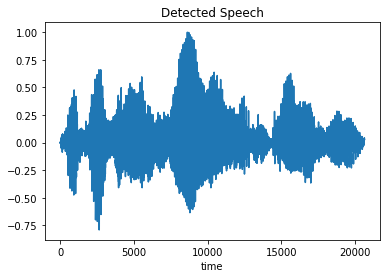

<Figure size 432x288 with 0 Axes>

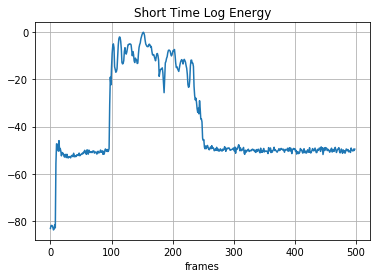

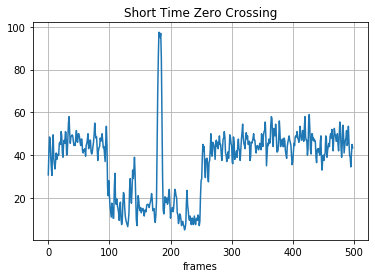

In [56]:
import numpy as np
dt = 1
t = np.arange(0, len(windowed_sound), dt)

plt.plot(data/max(data))
plt.title("Main Speech")
plt.xlabel("time")
plt.figure()

plt.plot(data[start_id:end_id]/max(data[start_id:end_id]))
plt.title("Detected Speech")
plt.xlabel("time")
plt.figure()


plt.figure()
plt.plot(t,shortTimeEnergy)
plt.grid(True)
plt.title("Short Time Log Energy")
plt.xlabel("frames")
plt.figure()

plt.plot(t, shortTimeZeroCrossing)
plt.grid(True)
plt.title("Short Time Zero Crossing")
plt.xlabel("frames")


In [42]:
wavio.write("detected3.wav", data[start_id:end_id], fs, sampwidth=2)
playsound("detected3.wav")